We can run the stress detection system by configuring file paths in the config.py and directly running the script stress_detection_system.py from command line.

This notebook is for running the stress detection system on 2024 data systematically. We also create visualisations for the manuscript here.
It performs:
- Loading Sentinel-2 images, extracting sugarbeet fields and saving them
- Modeling 2024 data
- Plots and diagrams used in the manuscript
- Creating deliverable images (stress maps) for 2024 data 

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')    #change according to system path

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [ ]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
from model_scripts.feature_extraction import *
from model_scripts.executions import *
import torch.nn.functional as F
from Experimentation.expt_scripts.sugarcontent_data_processing import *
from Experimentation.expt_scripts.expt_plots import *
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.regression import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.preprocess_script import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Data Prep: 3D_AE_B10 with encodings as addition



### Extracting sugar-beet fields and saving

In [10]:
# preprocessing_pipeline = PreProcessingPipelineTemporal()

# preprocessing_pipeline.run_temporal_patch_save_pipeline(type='train')
# preprocessing_pipeline.run_temporal_patch_save_pipeline(type='eval')

### Load Pre-process sub-patches

Dimensions: (N, T, C, H, W) = (N, 7, 10, 4, 4)

In [ ]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders_addition', tensor_type='b10_add', encoding_method='sin-cos', visualisation_images=False)

## Model prep: 3D_AE_B10 with encodings

### Load saved 3D Conv Autoencoder trained with temporal data
Redefine the architecture because the object needs to be created to load saved checkpoints

In [49]:
class Conv3DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Addition, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, T, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, T, 2)
        date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).permute(0, 2, 1)      # Shape: (B, 2, T)                         
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, T, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, T, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, T, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, T, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [26]:
device = 'cuda'
epochs = 50
momentum=0.9
lr = 0.001
vae_lr=0.001
latent_dim = 32
channels = 10
time_steps = 4
optimizer = 'Adam'
vae_optimizer = 'Adam'
patch_size = config.subpatch_size

#### NOTE: Skip the below cell to skip model training

In [ ]:
model_names = ["3D_AE_temporal_addition_2024"]
model_objs = [Conv3DAutoencoder_Time_Addition]  
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
        dataloader_eval=dataloader_eval,
        channels=channels,
        timestamps=time_steps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path
    )
    print("Model ",name," trained")


### Results

Loads from the saved results JSON

In [45]:
model_names = ['3D_AE_temporal_addition', "3D_AE_temporal_addition_2024"]
df_loss, df_accuracy, df_recall, df_f1, df_precision = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

In [46]:
df_f1

,Model,F1 Run 1,F1 Run 2,F1 Run 3,F1-score Avg
0,3D_AE_temporal_addition,75.32,75.32,75.00,75.213333
1,3D_AE_temporal_addition_2024,88.89,84.06,88.89,87.280000


In [47]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,3D_AE_temporal_addition,68.85,68.85,70.49,69.396667
1,3D_AE_temporal_addition_2024,80.00,72.50,80.00,77.500000


In [48]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333
1,3D_AE_temporal_addition_2024,91.43,82.86,91.43,88.573333


In [49]:
df_precision

,Model,Precision Run 1,Precision Run 2,Precision Run 3,Precision Avg
0,3D_AE_temporal_addition,69.05,69.05,72.97,70.356667
1,3D_AE_temporal_addition_2024,86.49,85.29,86.49,86.090000


## 2019 vs 2024 plot

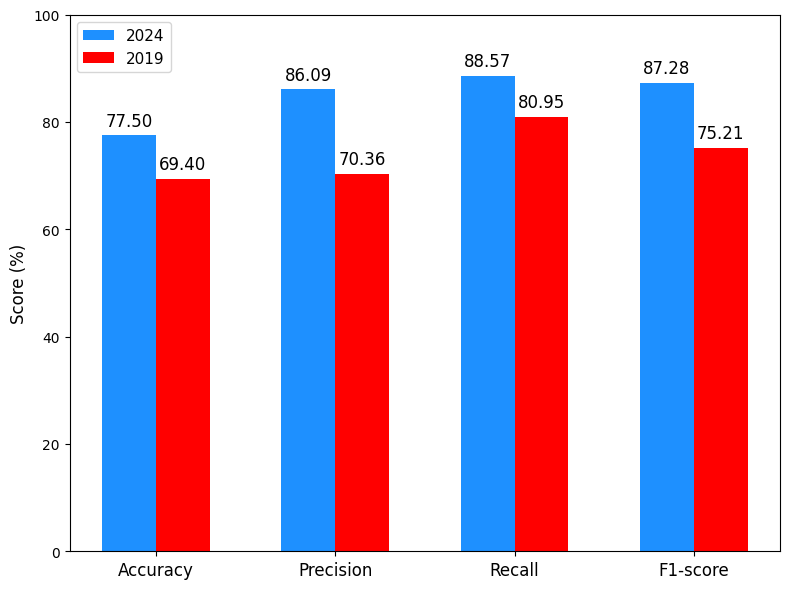

In [5]:
plot_2019_vs_2024()

## Reconstructions

### Extract Features for the data and cluster using k-means

In [ ]:
class Conv3DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Addition, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, T, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, T, 2)
        date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).permute(0, 2, 1)                                # Shape: (B, 2, T)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, T, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, T, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, T, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, T, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [52]:
channels = 10
time_steps = 4
latent_dim = 32
device = 'cuda'
trained_model = Conv3DAutoencoder_Time_Addition(channels, time_steps, latent_dim, config.subpatch_size)

with open(config.best_model_2024_path, 'rb') as file:
    trained_model = pickle.load(file)

/tmp/ipykernel_2736698/1106517536.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).permute(0, 2, 1)      # Shape: (B, 2, T)


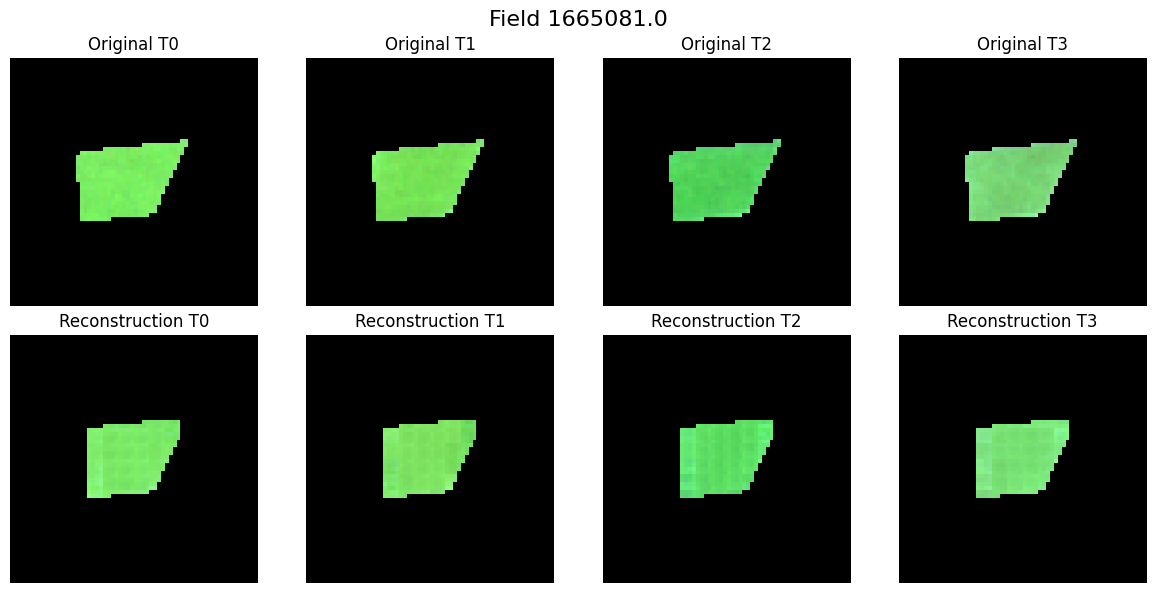

In [112]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, time_steps, 1, device, model_type='ae_te')

In [110]:
# plot_temporal_grid_reconstructions(trained_model, dataloader_eval, old_images_eval, T=time_steps, device=device, model_type='ae_te', num_fields=3)

## Stress-maps

In [ ]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=True, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=True, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=True, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [84]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=201)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [85]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 80.0
Precision: 86.49
Recall: 91.43
F1-score: 88.89
F2-score: 90.4


Assign field labels to training data for creating final visualisation images

In [86]:
train_field_labels = assign_field_labels_ae_train(combined_train_coords, train_subpatch_predictions, disease, config.subpatch_to_patch_threshold) #for box drawing

### Draw Diseased subpatches

In [89]:
eval_prediction_dict = dict(zip(eval_coord_dataloader, eval_subpatch_predictions))
train_prediction_dict = dict(zip(train_coord_dataloader, train_subpatch_predictions))

Eval Set

In [98]:
draw_diseased_patches_temporal(images_visualisation_eval, eval_prediction_dict, time_steps, config.deliverable_images_save_path, config.subpatch_size)

Saved: /home/k64835/SITS-images-2024/output/eval/1615767.png
Saved: /home/k64835/SITS-images-2024/output/eval/1620135.png
Saved: /home/k64835/SITS-images-2024/output/eval/1620135.png
Saved: /home/k64835/SITS-images-2024/output/eval/1625845.png
Saved: /home/k64835/SITS-images-2024/output/eval/1654428.png
Saved: /home/k64835/SITS-images-2024/output/eval/1663505.png
Saved: /home/k64835/SITS-images-2024/output/eval/1663637.png
Saved: /home/k64835/SITS-images-2024/output/eval/1663832.png
Saved: /home/k64835/SITS-images-2024/output/eval/1663841.png
Saved: /home/k64835/SITS-images-2024/output/eval/1664518.png
Saved: /home/k64835/SITS-images-2024/output/eval/1665081.png
Saved: /home/k64835/SITS-images-2024/output/eval/1665085.png
Saved: /home/k64835/SITS-images-2024/output/eval/1665121.png
Saved: /home/k64835/SITS-images-2024/output/eval/1665135.png
Saved: /home/k64835/SITS-images-2024/output/eval/1665159.png
Saved: /home/k64835/SITS-images-2024/output/eval/1665754.png
Saved: /home/k64835/SITS

Train Set

In [99]:
draw_diseased_patches_temporal(images_visualisation_train, train_prediction_dict, time_steps, config.deliverable_images_save_path, config.subpatch_size)

Saved: /home/k64835/SITS-images-2024/output/train/1615167.png
Saved: /home/k64835/SITS-images-2024/output/train/1615279.png
Saved: /home/k64835/SITS-images-2024/output/train/1615601.png
Saved: /home/k64835/SITS-images-2024/output/train/1615602.png
Saved: /home/k64835/SITS-images-2024/output/train/1615603.png
Saved: /home/k64835/SITS-images-2024/output/train/1615766.png
Saved: /home/k64835/SITS-images-2024/output/train/1615982.png
Saved: /home/k64835/SITS-images-2024/output/train/1616045.png
Saved: /home/k64835/SITS-images-2024/output/train/1616045.png
Saved: /home/k64835/SITS-images-2024/output/train/1616311.png
Saved: /home/k64835/SITS-images-2024/output/train/1616473.png
Saved: /home/k64835/SITS-images-2024/output/train/1616474.png
Saved: /home/k64835/SITS-images-2024/output/train/1616477.png
Saved: /home/k64835/SITS-images-2024/output/train/1616480.png
Saved: /home/k64835/SITS-images-2024/output/train/1616668.png
Saved: /home/k64835/SITS-images-2024/output/train/1616670.png
Saved: /